# Scenario 7 - XGBoost native

* Use XGBoost Regressor model to predict log SalePrice
* Allow native handling of categorical data
* Selected features based on results of SequentialFeatureSelector and Lasso models

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import xgboost as xgb

In [2]:
# Load the data
df = pd.read_csv(
    "../data/ames_housing_clean_1.csv",
    keep_default_na=False,  
    na_values=["", " "],
    dtype={'MSSubClass': 'str'}
)

In [4]:
# Create LogSalePrice target variable
df['LogSalePrice'] = np.log(df['SalePrice'])

# Define selected features
selected_features = [
    'BldgType', 'BsmtExposure', 'BsmtFinSF1', 'BsmtQual', 'Condition2', 
    'ExterCond', 'ExterQual', 'Exterior1st', 'Functional', 'GarageArea', 
    'GarageCond', 'GrLivArea', 'KitchenQual', 'MSSubClass', 'MSZoning', 
    'MasVnrArea', 'Neighborhood', 'OverallCond', 'OverallQual', 'RoofMatl', 
    'SaleCondition', 'TotalBsmtSF', 'YearBuilt', 'YearRemodAdd'
]

# Select features and target
X = df[selected_features].copy()
y = df['LogSalePrice'].copy()

print(f"Selected features: {len(selected_features)}")
print(f"Feature matrix shape: {X.shape}")

Selected features: 24
Feature matrix shape: (2576, 24)


In [5]:
# Check and print the total number of missing values
missing_y = y.isna().sum().sum()
total_missing_values = X.isna().sum().sum()
print(f"Total number of missing y values: {missing_y}")
print(f"Total number of missing X values: {total_missing_values}")

Total number of missing y values: 0
Total number of missing X values: 0


In [6]:
# Identify numeric and categorical features
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

print(f"\nNumeric features ({len(numeric_features)}): {numeric_features}")
print(f"Categorical features ({len(categorical_features)}): {categorical_features}")


Numeric features (9): ['BsmtFinSF1', 'GarageArea', 'GrLivArea', 'MasVnrArea', 'OverallCond', 'OverallQual', 'TotalBsmtSF', 'YearBuilt', 'YearRemodAdd']
Categorical features (15): ['BldgType', 'BsmtExposure', 'BsmtQual', 'Condition2', 'ExterCond', 'ExterQual', 'Exterior1st', 'Functional', 'GarageCond', 'KitchenQual', 'MSSubClass', 'MSZoning', 'Neighborhood', 'RoofMatl', 'SaleCondition']


In [7]:
# Convert selected features to 'category' type for native handling by XGB
for col in categorical_features:
    X[col] = X[col].astype('category')

print(f"Data types after conversion:\n{X.dtypes}")

Data types after conversion:
BldgType         category
BsmtExposure     category
BsmtFinSF1        float64
BsmtQual         category
Condition2       category
ExterCond        category
ExterQual        category
Exterior1st      category
Functional       category
GarageArea        float64
GarageCond       category
GrLivArea           int64
KitchenQual      category
MSSubClass       category
MSZoning         category
MasVnrArea        float64
Neighborhood     category
OverallCond         int64
OverallQual         int64
RoofMatl         category
SaleCondition    category
TotalBsmtSF       float64
YearBuilt           int64
YearRemodAdd        int64
dtype: object


In [8]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Scale only numeric features manually
scaler = StandardScaler()

# Create copies to avoid modifying originals
X_train_processed = X_train.copy()
X_test_processed = X_test.copy()

# Scale only numeric columns
X_train_processed[numeric_features] = scaler.fit_transform(X_train[numeric_features])
X_test_processed[numeric_features] = scaler.transform(X_test[numeric_features])

print(f"Processed feature matrix shape: {X_train_processed.shape}")

Processed feature matrix shape: (2060, 24)


In [9]:
# Hyperparameter tuning with GridSearch
print(f"\n=== HYPERPARAMETER TUNING ===")
print("Starting grid search for optimal hyperparameters...")

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.05, 0.1, 0.15],
    'subsample': [0.8, 0.9]
}

xgb_grid = xgb.XGBRegressor(random_state=42, enable_categorical=True)

grid_search = GridSearchCV(
    xgb_grid, 
    param_grid, 
    cv=5, 
    scoring='r2', 
    n_jobs=-1, 
    verbose=1
)

grid_search.fit(X_train_processed, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best CV score: {grid_search.best_score_:.4f}")


=== HYPERPARAMETER TUNING ===
Starting grid search for optimal hyperparameters...
Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best parameters: {'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 300, 'subsample': 0.8}
Best CV score: 0.9086


In [10]:
# Train final model with best parameters
best_xgb = grid_search.best_estimator_
y_test_pred = best_xgb.predict(X_test_processed)
y_train_pred = best_xgb.predict(X_train_processed)

# Calculate metrics
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

# Final model summary
print(f"\n=== XGBoost MODEL PERFORMANCE ===")
print(f"Training R²: {train_r2:.4f}")
print(f"Test R²: {test_r2:.4f}")
print(f"Training RMSE: {train_rmse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Training MAE: {train_mae:.4f}")
print(f"Test MAE: {test_mae:.4f}")


=== XGBoost MODEL PERFORMANCE ===
Training R²: 0.9779
Test R²: 0.9290
Training RMSE: 0.0577
Test RMSE: 0.1026
Training MAE: 0.0433
Test MAE: 0.0761


In [11]:
# Feature importance analysis
feature_importance = pd.DataFrame({
    'feature': X_train_processed.columns,  # Use processed column names
    'importance': best_xgb.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\n=== TOP 15 FEATURE IMPORTANCES ===")
feature_importance.head(15)


=== TOP 15 FEATURE IMPORTANCES ===


,feature,importance
18,OverallQual,0.465075
12,KitchenQual,0.149859
11,GrLivArea,0.071816
16,Neighborhood,0.046357
21,TotalBsmtSF,0.041431
9,GarageArea,0.039294
10,GarageCond,0.031049
17,OverallCond,0.022214
23,YearRemodAdd,0.015663
13,MSSubClass,0.015149


In [12]:
# Cross-validation
cv_scores = cross_val_score(best_xgb, X_train_processed, y_train, cv=5, scoring='r2')
print(f"\n=== CROSS-VALIDATION RESULTS ===")
print(f"CV R² scores: {cv_scores}")
print(f"Mean CV R²: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")



=== CROSS-VALIDATION RESULTS ===
CV R² scores: [0.8734984  0.93146498 0.91090903 0.90914562 0.9181803 ]
Mean CV R²: 0.9086 (+/- 0.0385)


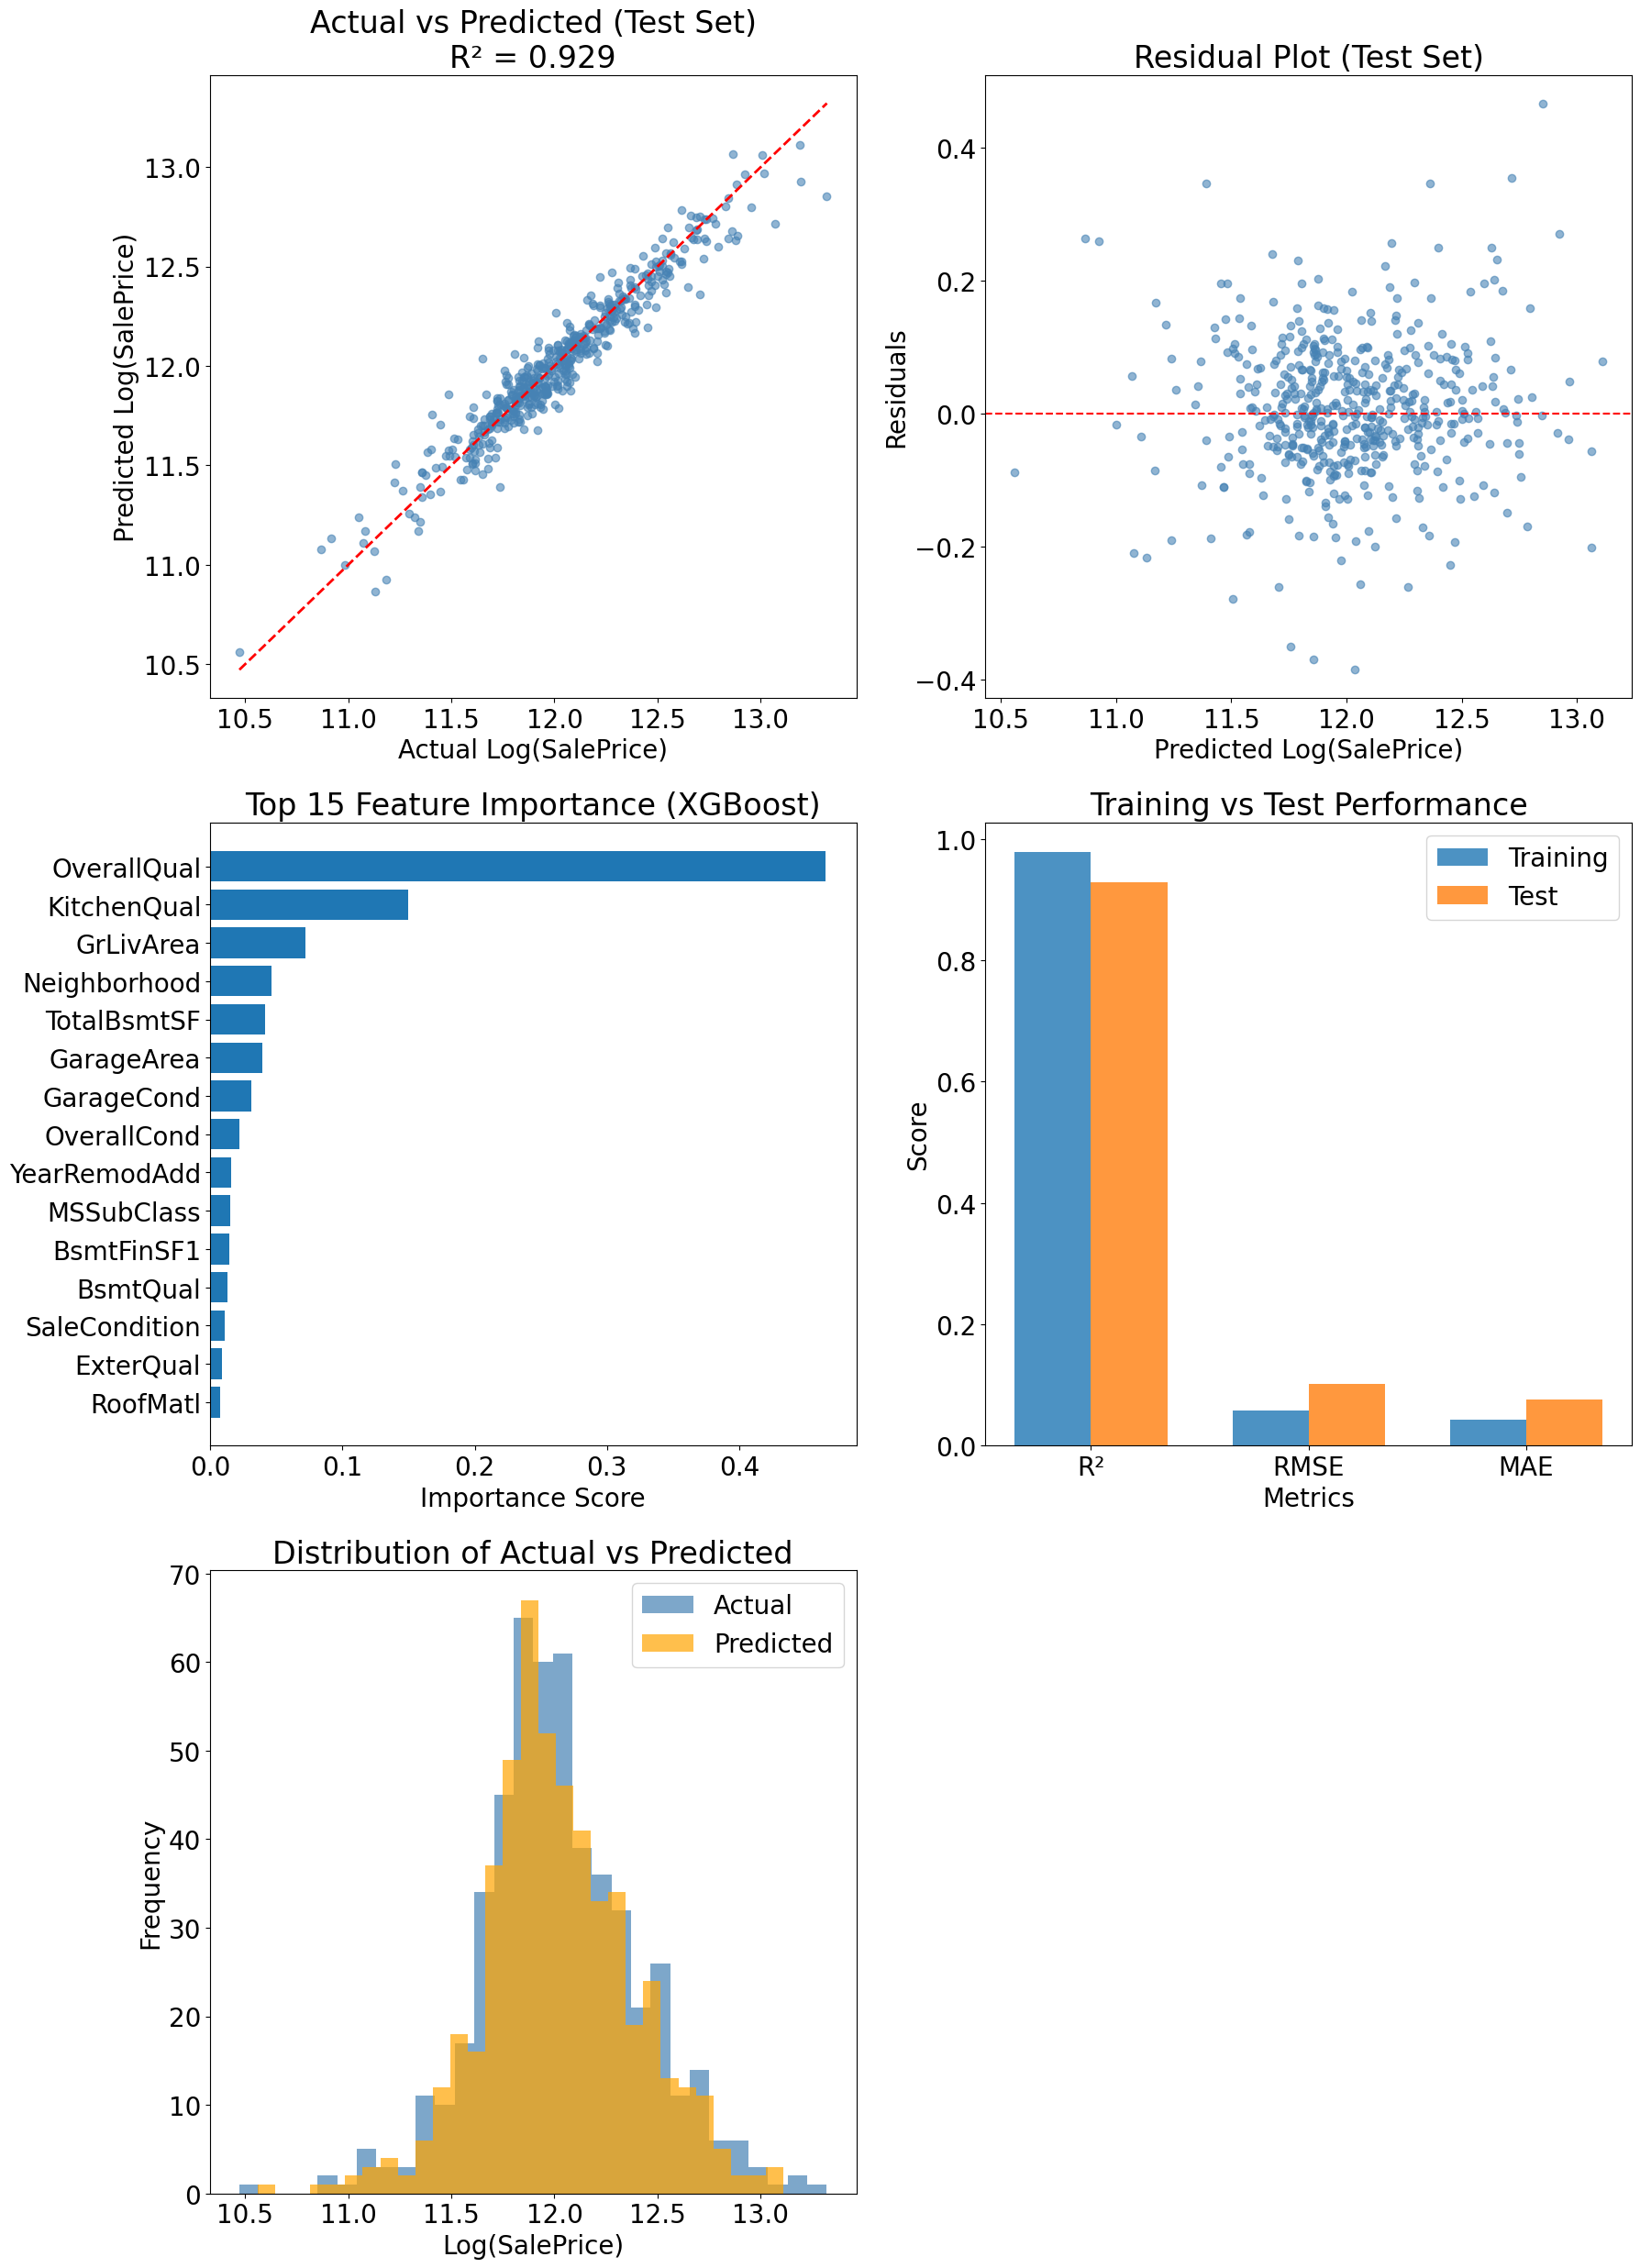

In [13]:
# Create comprehensive visualizations
plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(20, 30))

# Plot 1: Actual vs Predicted (Test Set)
plt.subplot(3, 2, 1)
plt.scatter(y_test, y_test_pred, alpha=0.6, color='steelblue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Log(SalePrice)')
plt.ylabel('Predicted Log(SalePrice)')
plt.title(f'Actual vs Predicted (Test Set)\nR² = {test_r2:.3f}')

# Plot 2: Residuals
plt.subplot(3, 2, 2)
residuals = y_test - y_test_pred
plt.scatter(y_test_pred, residuals, alpha=0.6, color='steelblue')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Log(SalePrice)')
plt.ylabel('Residuals')
plt.title('Residual Plot (Test Set)')

# Plot 3: Feature Importance (Top 15)
plt.subplot(3, 2, 3)
top_15 = feature_importance.head(15)
plt.barh(range(len(top_15)), top_15['importance'])
plt.yticks(range(len(top_15)), [f[:20] + '...' if len(f) > 20 else f for f in top_15['feature']])
plt.xlabel('Importance Score')
plt.title('Top 15 Feature Importance (XGBoost)')
plt.gca().invert_yaxis()

# Plot 4: Training vs Test Performance
plt.subplot(3, 2, 4)
metrics = ['R²', 'RMSE', 'MAE']
train_scores = [train_r2, train_rmse, train_mae]
test_scores = [test_r2, test_rmse, test_mae]
x = np.arange(len(metrics))
width = 0.35
plt.bar(x - width/2, train_scores, width, label='Training', alpha=0.8)
plt.bar(x + width/2, test_scores, width, label='Test', alpha=0.8)
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Training vs Test Performance')
plt.xticks(x, metrics)
plt.legend()

# Plot 5: Prediction distribution
plt.subplot(3, 2, 5)
plt.hist(y_test, alpha=0.7, label='Actual', bins=30, color='steelblue')
plt.hist(y_test_pred, alpha=0.7, label='Predicted', bins=30, color='orange')
plt.xlabel('Log(SalePrice)')
plt.ylabel('Frequency')
plt.title('Distribution of Actual vs Predicted')
plt.legend()

# # Plot 7: Feature importance by category
# plt.subplot(3, 2, 6)
# # Separate numeric and categorical feature importance
# numeric_importance = feature_importance[feature_importance['feature'].isin(numeric_features)]
# categorical_importance = feature_importance[~feature_importance['feature'].isin(numeric_features)]

# categories = ['Numeric', 'Categorical']
# importance_sums = [numeric_importance['importance'].sum(), categorical_importance['importance'].sum()]
# plt.pie(importance_sums, labels=categories, autopct='%1.1f%%', startangle=90)
# plt.title('Feature Importance by Type')



# Top Features vs Log SalePrice

In [14]:
import re
top_features = feature_importance.head(15).copy()
# top_features = feature_importance.copy()
# Extract base feature names by removing text after underscore
top_features['feature'] = top_features['feature'].str.replace(r'_.*', '', regex=True)
# print(top_features)
# Group by the modified feature names and sum the importance values
top_features = top_features.groupby('feature', as_index=False)['importance'].sum()
top_features = top_features.sort_values('importance', ascending=False)
top_features

,feature,importance
10,OverallQual,0.465075
6,KitchenQual,0.149859
5,GrLivArea,0.071816
8,Neighborhood,0.046357
13,TotalBsmtSF,0.041431
3,GarageArea,0.039294
4,GarageCond,0.031049
9,OverallCond,0.022214
14,YearRemodAdd,0.015663
7,MSSubClass,0.015149


In [15]:
def plot_numeric_relationship(df, feature, target='LogSalePrice', figsize=(10, 6)):
    """Plot relationship between numeric feature and target"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    
    # Remove missing values for this feature
    mask = df[feature].notna() & df[target].notna()
    x_data = df.loc[mask, feature]
    y_data = df.loc[mask, target]
    
    # Scatter plot with trend line
    ax1.scatter(x_data, y_data, alpha=0.6, color='steelblue', s=20)
    
    # Add trend line
    z = np.polyfit(x_data, y_data, 1)
    p = np.poly1d(z)
    x_range = np.linspace(x_data.min(), x_data.max(), 100)
    ax1.plot(x_range, p(x_range), "r--", alpha=0.8, linewidth=2)
    
    # Calculate correlation
    correlation = x_data.corr(y_data)
    
    ax1.set_xlabel(feature, fontweight='bold')
    ax1.set_ylabel('LogSalePrice', fontweight='bold')
    ax1.set_title(f'{feature} vs LogSalePrice\nCorrelation: {correlation:.3f}', fontweight='bold')
    ax1.grid(True, alpha=0.3)
    
    # Distribution plot
    ax2.hist(x_data, bins=30, alpha=0.7, color='lightblue', edgecolor='black')
    ax2.set_xlabel(feature, fontweight='bold')
    ax2.set_ylabel('Frequency', fontweight='bold')
    ax2.set_title(f'Distribution of {feature}', fontweight='bold')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print(f"\n{feature} Statistics:")
    print(f"  Correlation with LogSalePrice: {correlation:.4f}")
    print(f"  Feature range: {x_data.min():.1f} to {x_data.max():.1f}")
    print(f"  Feature mean: {x_data.mean():.1f}")
    print(f"  Sample size: {len(x_data):,}")


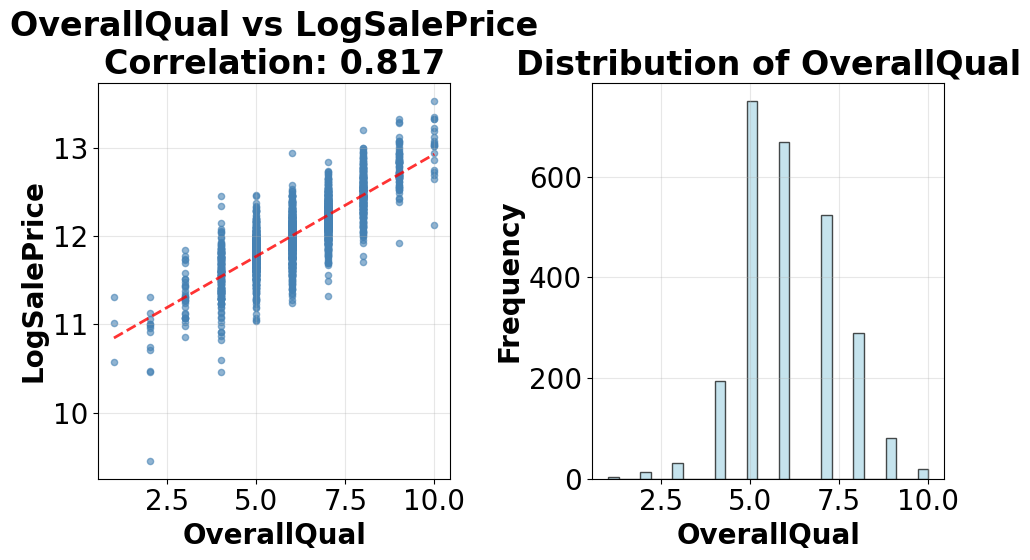


OverallQual Statistics:
  Correlation with LogSalePrice: 0.8167
  Feature range: 1.0 to 10.0
  Feature mean: 6.0
  Sample size: 2,576


In [16]:
plot_numeric_relationship(df, "OverallQual")

In [17]:
import seaborn as sns
from scipy import stats

In [18]:
def plot_categorical_relationship(df, feature, target='LogSalePrice', figsize=(12, 8)):
    """Plot relationship between categorical feature and target"""
    # Remove missing values
    mask = df[feature].notna() & df[target].notna()
    df_clean = df.loc[mask, [feature, target]].copy()
    
    if df_clean.empty:
        print(f"No valid data for {feature}")
        return
    
    # Calculate statistics by category
    stats_by_category = df_clean.groupby(feature)[target].agg([
        'count', 'mean', 'median', 'std'
    ]).round(3)
    
    # Sort categories by mean LogSalePrice
    category_order = stats_by_category.sort_values('mean', ascending=False).index
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=figsize)
    
    # Box plot
    df_clean[feature] = pd.Categorical(df_clean[feature], categories=category_order, ordered=True)
    sns.boxplot(data=df_clean, x=feature, y=target, ax=ax1)
    ax1.set_title(f'{feature} vs {target} (Box Plot)', fontweight='bold')
    ax1.tick_params(axis='x', rotation=45)
    ax1.grid(True, alpha=0.3)
    
    # Violin plot
    sns.violinplot(data=df_clean, x=feature, y=target, ax=ax2)
    ax2.set_title(f'{feature} vs {target} (Violin Plot)', fontweight='bold')
    ax2.tick_params(axis='x', rotation=45)
    ax2.grid(True, alpha=0.3)
    
    # Mean values bar plot
    means = stats_by_category.loc[category_order, 'mean']
    colors = plt.cm.RdYlBu_r(np.linspace(0.2, 0.8, len(means)))
    bars = ax3.bar(range(len(means)), means.values, color=colors)
    ax3.set_xlabel(feature, fontweight='bold')
    ax3.set_ylabel(f'Mean {target}', fontweight='bold')
    ax3.set_title(f'Mean {target} by {feature}', fontweight='bold')
    ax3.set_xticks(range(len(means)))
    ax3.set_xticklabels(means.index, rotation=45)
    ax3.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for bar, value in zip(bars, means.values):
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{value:.3f}', ha='center', va='bottom', fontweight='bold')
    
    # Sample size plot
    counts = stats_by_category.loc[category_order, 'count']
    ax4.bar(range(len(counts)), counts.values, color='lightgreen', alpha=0.7)
    ax4.set_xlabel(feature, fontweight='bold')
    ax4.set_ylabel('Sample Size', fontweight='bold')
    ax4.set_title(f'Sample Size by {feature}', fontweight='bold')
    ax4.set_xticks(range(len(counts)))
    ax4.set_xticklabels(counts.index, rotation=45)
    ax4.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for i, (bar, value) in enumerate(zip(ax4.patches, counts.values)):
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height + max(counts)*0.01,
                f'{int(value)}', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed statistics
    print(f"\n{feature} Statistics (sorted by mean LogSalePrice):")
    print("=" * 70)
    print(f"{'Category':<15} {'Count':<8} {'Mean':<8} {'Median':<8} {'Std':<8}")
    print("=" * 70)
    for category in category_order:
        row = stats_by_category.loc[category]
        print(f"{str(category):<15} {int(row['count']):<8} {row['mean']:<8.3f} {row['median']:<8.3f} {row['std']:<8.3f}")


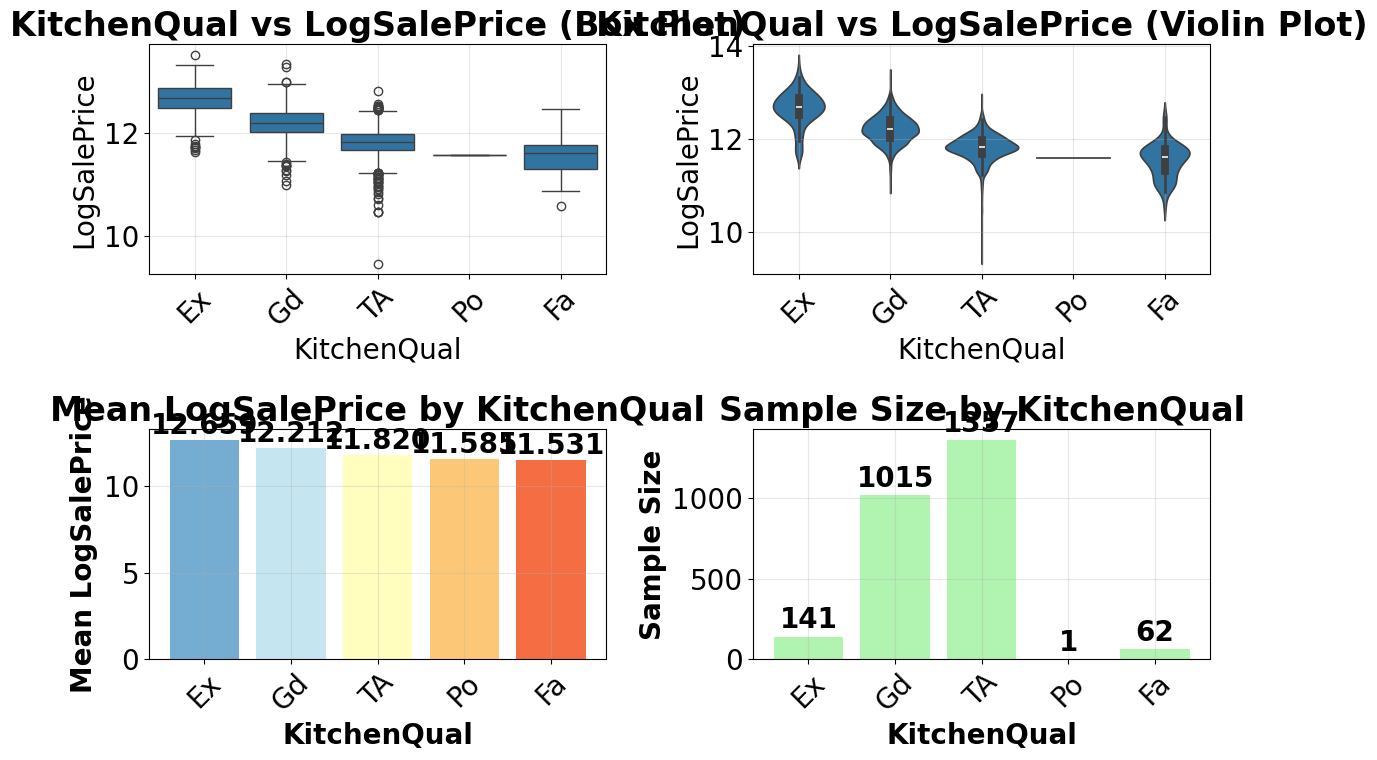


KitchenQual Statistics (sorted by mean LogSalePrice):
Category        Count    Mean     Median   Std     
Ex              141      12.659   12.688   0.363   
Gd              1015     12.212   12.206   0.295   
TA              1357     11.820   11.831   0.281   
Po              1        11.585   11.585   nan     
Fa              62       11.531   11.622   0.362   


In [19]:
plot_categorical_relationship(df, "KitchenQual")